# F1 Qualifying Position vs. Race Finish Position Performance Analysis (2021 - 2024 Season)

# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import os
import glob
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
csv_folder_path = 'F1dataset' 
database_path = 'f1_project.db'

con = sqlite3.connect(database_path)

csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv'))

for file in csv_files:
    df = pd.read_csv(file)
    
    table_name = os.path.splitext(os.path.basename(file))[0]
    
    df.to_sql(table_name, con, if_exists='replace', index=False)
    
    print(f"Loaded {table_name} into the database.")

Loaded circuits into the database.
Loaded constructors into the database.
Loaded constructor_results into the database.
Loaded constructor_standings into the database.
Loaded drivers into the database.
Loaded driver_standings into the database.
Loaded lap_times into the database.
Loaded pit_stops into the database.
Loaded qualifying into the database.
Loaded races into the database.
Loaded results into the database.
Loaded seasons into the database.
Loaded sprint_results into the database.
Loaded status into the database.


# Building the Master F1 Analysis Dataset

In [3]:
create_tables_script = """
        DROP TABLE IF EXISTS master_analysis_data;
        DROP TABLE IF EXISTS master_finished_analysis_data;

        CREATE TABLE master_analysis_data AS
        SELECT  rc.year,
                rc.name AS raceName,
                dv.forename || ' ' || dv.surname AS driver,
                cs.name AS constructorName,
                re.grid AS grid,
                qf.position AS qualifyingPosition,
                re.positionOrder AS racePosition,
                re.laps AS laps,
                st.status AS status
        FROM races AS rc
        INNER JOIN results AS re ON rc.raceID = re.raceID
        INNER JOIN drivers AS dv ON re.driverID = dv.driverID
        INNER JOIN constructors AS cs ON re.constructorId = cs.constructorId
        INNER JOIN qualifying AS qf ON  rc.raceID = qf.raceID 
                AND re.driverID = qf.driverID
        INNER JOIN status AS st on re.statusID = st.statusID
        WHERE year >= 2021
                AND year <= 2024;

        CREATE TABLE master_finished_analysis_data AS
        SELECT *
        FROM master_analysis_data
        WHERE status = 'Finished'
"""

with sqlite3.connect("f1_project.db") as con:
        con.executescript(create_tables_script)


analysis_finished_query = """
    SELECT * 
    FROM master_finished_analysis_data
"""
with sqlite3.connect("f1_project.db") as con:
        analysis_finished_df = pd.read_sql_query(analysis_finished_query, con)


analysis_finished_df.head()

,year,raceName,driver,constructorName,grid,qualifyingPosition,racePosition,laps,status
0,2021,Emilia Romagna Grand Prix,Lewis Hamilton,Mercedes,1,1,2,63,Finished
1,2021,Emilia Romagna Grand Prix,Fernando Alonso,Alpine F1 Team,15,15,10,63,Finished
2,2021,Emilia Romagna Grand Prix,Kimi Räikkönen,Alfa Romeo,16,16,13,63,Finished
3,2021,Emilia Romagna Grand Prix,Sergio Pérez,Red Bull,2,2,11,63,Finished
4,2021,Emilia Romagna Grand Prix,Daniel Ricciardo,McLaren,6,6,6,63,Finished


# Creating visualizations

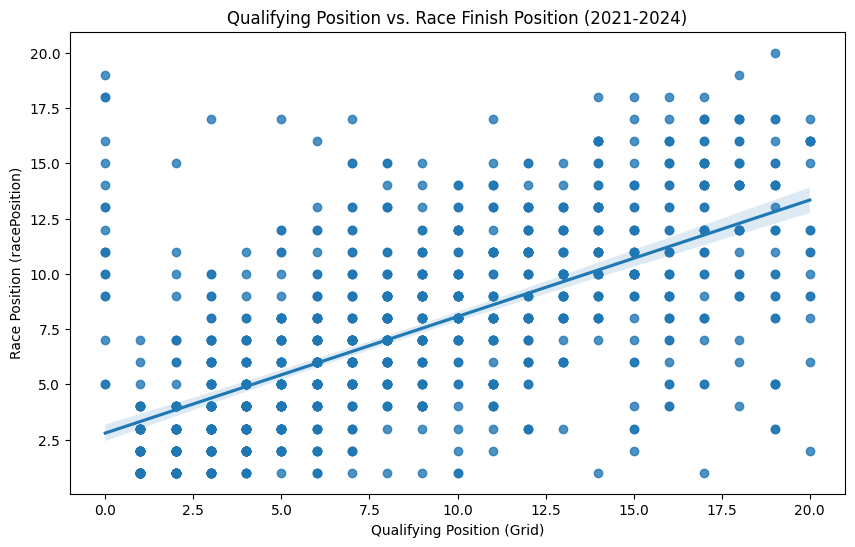

In [4]:
plt.figure(figsize=(10, 6))
sns.regplot(data=analysis_finished_df, x='grid', y='racePosition')
plt.title('Qualifying Position vs. Race Finish Position (2021-2024)')
plt.xlabel('Qualifying Position (Grid)')
plt.ylabel('Race Position (racePosition)')

plt.show()

The regression plot above visualizes the relationship between a driver's starting grid position and their final race position for the 2021-2024 F1 seasons.

The clear upward-sloping trendline shows a strong positive correlation between the two variables. This indicates that, on average, a driver's starting position is a strong predictor of their finishing position.

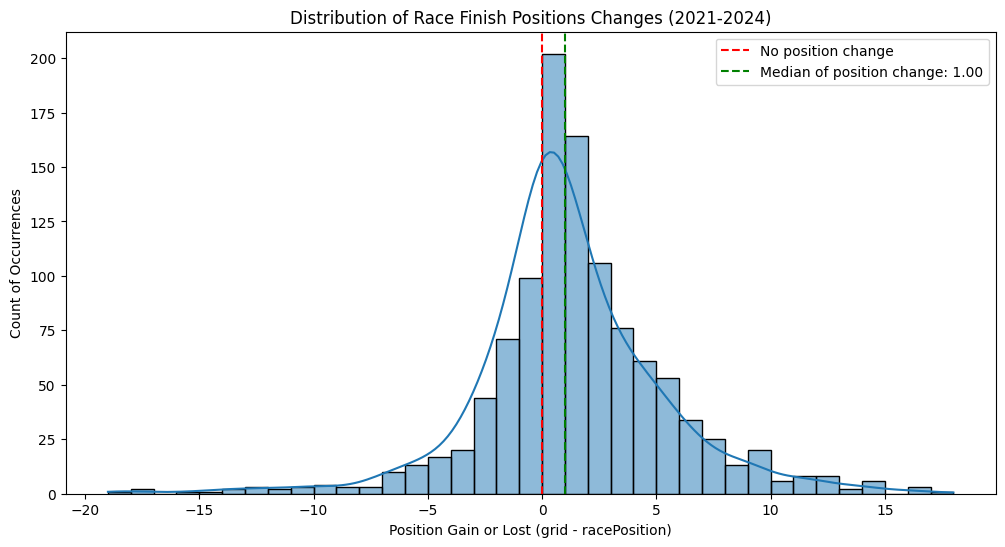

In [5]:
position_change_query = """
    SELECT (grid - racePosition) AS position_change
    FROM master_finished_analysis_data
"""

with sqlite3.connect("f1_project.db") as con:
    position_change_df = pd.read_sql_query(position_change_query, con)

median_change = position_change_df['position_change'].median()
plt.figure(figsize=(12, 6))
sns.histplot(position_change_df, x = 'position_change', binwidth = 1, kde=True)
plt.axvline(0, color='red', linestyle='--', label='No position change')
plt.axvline(median_change, color='green', linestyle='--', label=f'Median of position change: {median_change:.2f}')
plt.legend()

plt.title('Distribution of Race Finish Positions Changes (2021-2024)')
plt.xlabel('Position Gain or Lost (grid - racePosition)')
plt.ylabel('Count of Occurrences')

plt.show()

The histogram central peak is at the range [0,1], indicating that most common outcome is drivers finishing their race in or very near their starting grid position.

Also, from the distribution, we can see that large position changes (gain or lose position over 10), are rarely happened.

The median of the distribution is 1.0. A positive median suggests that drivers are more likely to gain position rather than lose position.

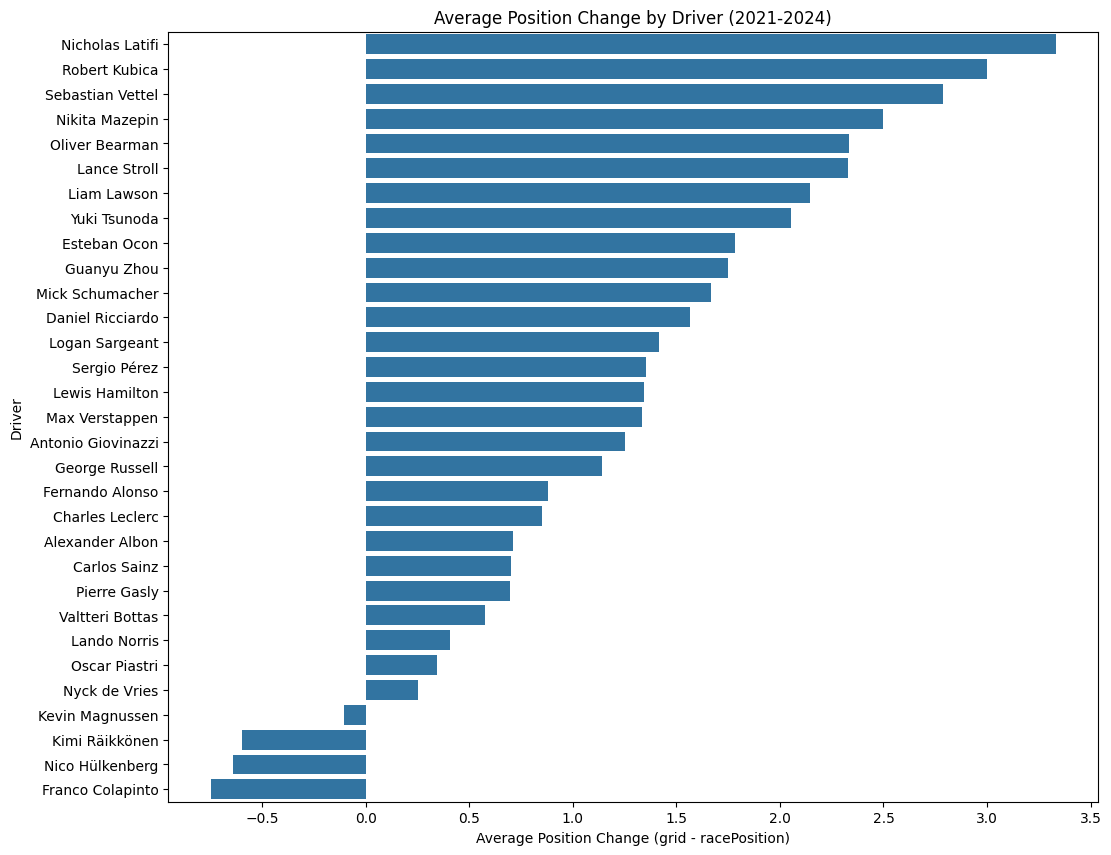

In [6]:
driver_performance_query = """
    SELECT avg(grid - racePosition) AS avg_position_change,
        driver
    FROM master_finished_analysis_data
    GROUP BY driver
    ORDER BY avg_position_change DESC
"""

with sqlite3.connect("f1_project.db") as con:
    driver_performance_df = pd.read_sql_query(driver_performance_query, con)

plt.figure(figsize=(12, 10))
sns.barplot(data=driver_performance_df, x='avg_position_change', y='driver', orient='h')

plt.title('Average Position Change by Driver (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Driver')

plt.show()

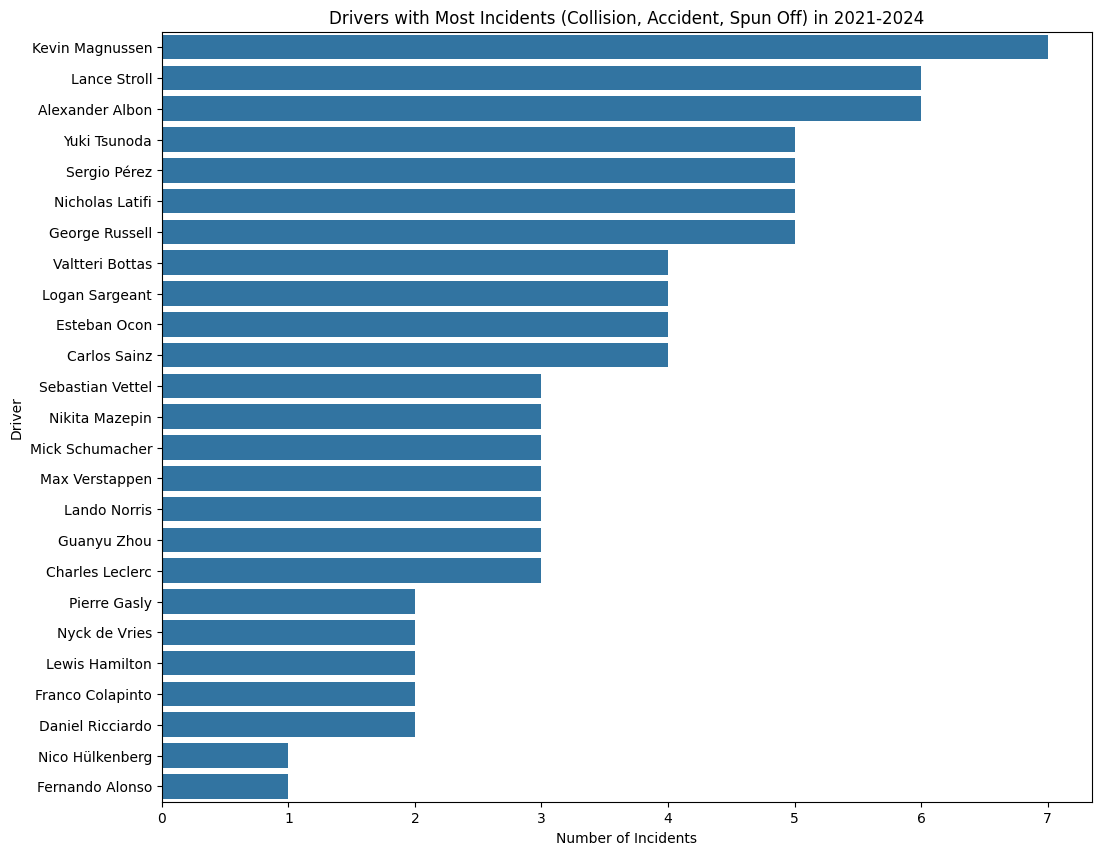

In [7]:
driver_incident_counts_query = """
    SELECT driver, count(1) AS number_of_incidents
    FROM  master_analysis_data
    WHERE status IN ('Collision',
                    'Accident',
                    'Spun Off',
                    'Damage',
                    'Puncture',
                    'Front wing',
                    'Rear wing')
    GROUP BY driver
    ORDER BY number_of_incidents DESC
"""

with sqlite3.connect("f1_project.db") as con:
    driver_incident_counts_df = pd.read_sql_query(driver_incident_counts_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=driver_incident_counts_df, x='number_of_incidents', y='driver', orient='h')

plt.title('Drivers with Most Incidents (Collision, Accident, Spun Off) in 2021-2024')
plt.xlabel('Number of Incidents')
plt.ylabel('Driver')

plt.show()

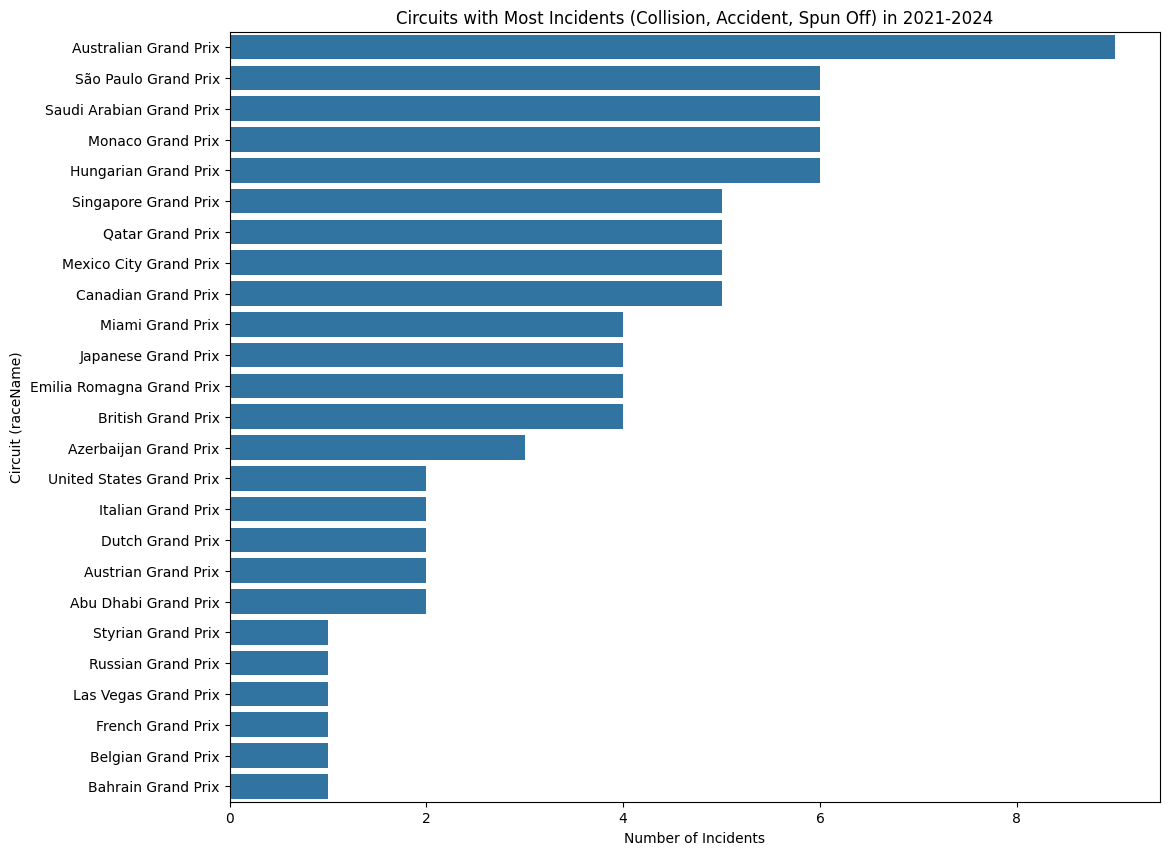

In [8]:
circuit_incidents_count_query = """
    SELECT raceName, count(1) AS number_of_incidents
    FROM  master_analysis_data
    WHERE status IN ('Collision',
                    'Accident',
                    'Spun Off',
                    'Damage',
                    'Puncture',
                    'Front wing',
                    'Rear wing')
    GROUP BY raceName
    ORDER BY number_of_incidents DESC
"""

with sqlite3.connect("f1_project.db") as con:
    circuit_incidents_count_df = pd.read_sql_query(circuit_incidents_count_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=circuit_incidents_count_df, x='number_of_incidents', y='raceName', orient='h')

plt.title('Circuits with Most Incidents (Collision, Accident, Spun Off) in 2021-2024')
plt.xlabel('Number of Incidents')
plt.ylabel('Circuit (raceName)')

plt.show()

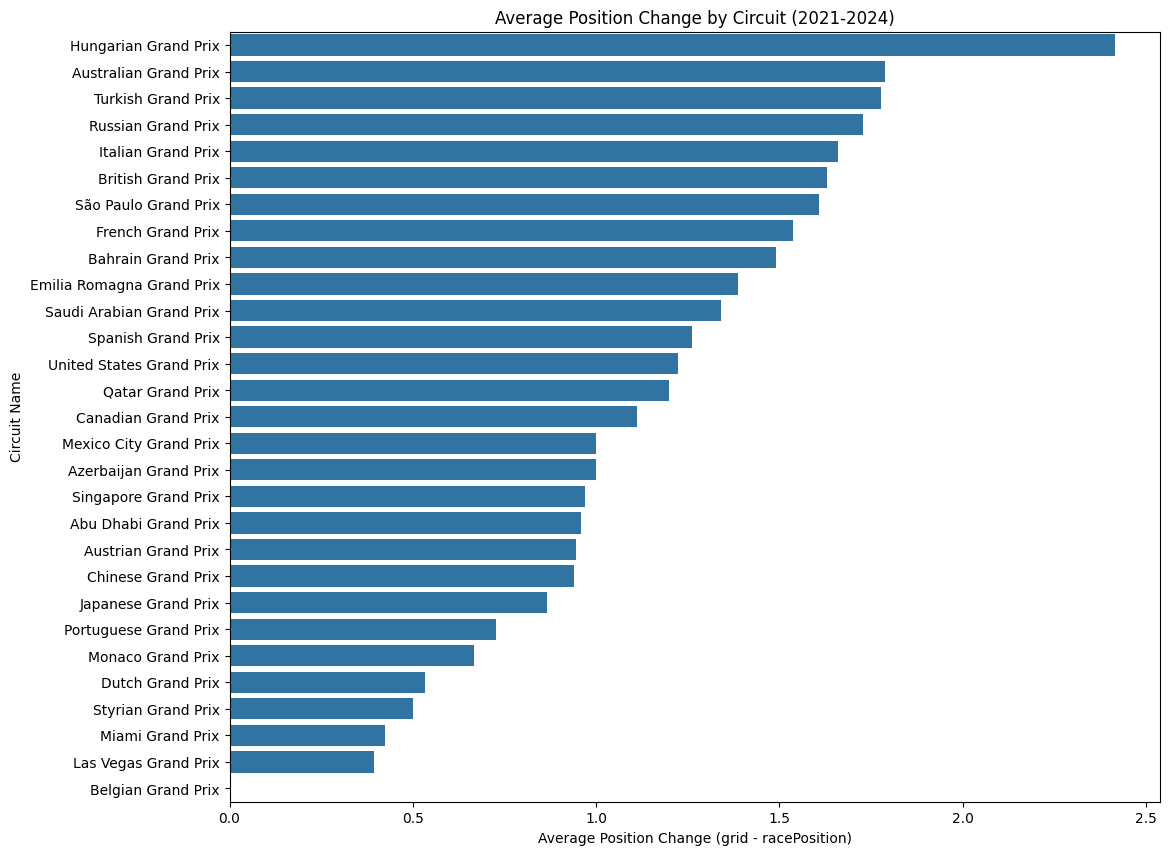

In [3]:
circuit_get_positions_query = """
    SELECT raceName, avg(grid - racePosition) AS position_change
    FROM master_finished_analysis_data
    GROUP BY raceName
    ORDER BY position_change DESC
"""

with sqlite3.connect("f1_project.db") as con:
    circuit_get_positions_df = pd.read_sql_query(circuit_get_positions_query, con)


plt.figure(figsize=(12, 10))
sns.barplot(data=circuit_get_positions_df, x='position_change', y='raceName', orient='h')

plt.title('Average Position Change by Circuit (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Circuit Name')

plt.show()

Next, I want to investgate "why", and answer the questions below:

1. Circuit Type: Does the type of circuit (e.g., a high-speed circuit like Monza vs. a low-speed circuit like Monaco) have a significant impact on overall position changes?

2. Race Chaos: Do races with more incidents (collisions, accidents, spins) show a wider distribution of position changes?

In [1]:
circuit_map = {'Australian Grand Prix': 'High Speed',
    'Italian Grand Prix': 'High Speed',
    'Styrian Grand Prix': 'High Speed',
    'Bahrain Grand Prix': 'Medium Speed',
    'Japanese Grand Prix': 'High Speed',
    'Abu Dhabi Grand Prix': 'Low Speed',
    'Chinese Grand Prix': 'Medium Speed',
    'Saudi Arabian Grand Prix': 'High Speed',
    'Monaco Grand Prix': 'Low Speed',
    'São Paulo Grand Prix': 'Low Speed',
    'British Grand Prix': 'High Speed',
    'Emilia Romagna Grand Prix': 'Medium Speed',
    'Hungarian Grand Prix': 'Low Speed',
    'Mexico City Grand Prix': 'Low Speed',
    'Qatar Grand Prix': 'Medium Speed',
    'United States Grand Prix': 'Medium Speed',
    'Singapore Grand Prix': 'Low Speed',
    'Azerbaijan Grand Prix': 'Medium Speed',
    'Canadian Grand Prix': 'Medium Speed',
    'Miami Grand Prix': 'Medium Speed',
    'Portuguese Grand Prix': 'Medium Speed',
    'Las Vegas Grand Prix': 'Medium Speed',
    'French Grand Prix': 'Medium Speed',
    'Austrian Grand Prix': 'High Speed',
    'Spanish Grand Prix': 'Medium Speed',
    'Turkish Grand Prix': 'Medium Speed',
    'Belgian Grand Prix': 'High Speed',
    'Dutch Grand Prix': 'Low Speed'
}

analysis_finished_df['circuitType'] = analysis_finished_df['raceName'].map(circuit_map)
circuit_type_performance = analysis_finished_df.groupby('circuitType')['position_change'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=circuit_type_performance, x='position_change', y='circuitType', orient='h')

plt.title('Average Position Change by Circuit Type (2021-2024)')
plt.xlabel('Average Position Change (grid - racePosition)')
plt.ylabel('Circuit Type')

plt.show()

NameError: name 'analysis_finished_df' is not defined

High Speed circuits yield the highest position gain(~0.75);  Low Speed circuits also show high gain(~0.6); Medium Speed circuits show the lowest gain (~0.49).